In [1]:
# https://github.com/udacity/deep-learning/blob/master/seq2seq/sequence_to_sequence_implementation.ipynb
# https://github.com/Currie32/Text-Summarization-with-Amazon-Reviews/blob/master/summarize_reviews.ipynb
# https://github.com/Tony607/Summarizing_Text_Amazon_Reviews/blob/master/summarize_reviews.ipynb


# https://stackoverflow.com/questions/36382508/packages-from-conda-env-not-found-in-jupyer-notebook
# import sys
# sys.executable

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from os import listdir
import re
import pandas as pd
import glob
import unicodedata
import string
import datetime
import time
from tqdm import tqdm

import copy
import pickle

from collections import Counter

import tensorflow as tf

In [3]:
# TODO: put back </s> ?

path = "./data" 

train_raw_all = []

for filename in tqdm(listdir(path)):
    if 'train' in filename:
        print(filename)
        path_file = path + '/' + filename
        with open(path_file, 'r', encoding='utf-8',errors='ignore') as binary_file:
            raw_text = binary_file.read()
            raw_text = raw_text.replace('<s>', '')
            raw_text = raw_text.replace('</s>', '')
            raw_text = raw_text.replace('\n', '')
            raw_text = raw_text.replace('-lrb- ', '')
            raw_text = raw_text.replace('-rrb- ', '')
            #raw_text = re.sub(r"\\x(.*?)\d+", '', raw_text)
            raw_text = re.sub(r"\d", '#', raw_text)
            raw_text = raw_text.replace('\x12', '') 
            raw_text = raw_text.replace('\x17', '')
            raw_text = raw_text.replace('\x18', '')
            raw_text = raw_text.replace('\x01', '')
            raw_text = raw_text.replace('\x02', '')
            raw_text = raw_text.replace('\x03', '')
            raw_text = raw_text.replace('\x06', '')
            raw_text = raw_text.replace('\x00', '')
            raw_text = raw_text.replace('\x11', '')
            raw_text = raw_text.replace('\x13', '')
            raw_text = raw_text.replace('\x14', '')
            raw_text = raw_text.replace('\x15', '')
            abstract = raw_text.split('\x08abstract') # .decode('utf-8', 'ignore')ISO-8859-1 
            x = [a.split('\x07article') for a in abstract]
            train_raw_all.extend(x[1:])
   
        
# df = pd.DataFrame(data=train_raw_all, columns=['abstract','article']) # df = df.ix[1:]
# s = {'<s>':'', '</s>':''}
# df['abstract'] = df['abstract'].replace(s)

#df['abstract'] = df['abstract'].apply(lambda x: x.split('<s>',1)[-1])
#df['article'] = df['article'].apply(lambda x: x.split('-rrb-',1)[-1])

print('done!')

  0%|          | 0/7 [00:00<?, ?it/s]

train.bin


100%|██████████| 7/7 [01:26<00:00, 12.29s/it]

done!


In [5]:
(train_raw_all[797])

[" new bills officially come into circulation monday .   bills are n't enough to buy a loaf of bread . they can only buy four oranges .   gideon gono : notes for `` convenience of the banking public and corporate sector ''   the new note is equal to just one u.s. dollar . \x0f",
 "\x0f\x0f\x0fharare , zimbabwe cnn -- zimbabwe 's troubled central bank introduced $ ### billion banknotes saturday in a desperate bid to ease the recurrent cash shortages plaguing the inflation-ravaged economy . a shopper displays a $ ### million zimbabwean bank note . the bills officially come into circulation monday , although they were on the foreign currency dealers market saturday . as high as they are , though , the bills still are n't enough to buy a loaf of bread . they can buy only four oranges . the new note is equal to just one u.s. dollar . once-prosperous zimbabwe has seen an unprecedented economic meltdown since it gained independence in #### , with the official inflation rate now at #.# million

In [3]:
source_text = (' <END> ').join([a[1] for a in train_raw_all])
target_text = (' <END> ').join([a[0] for a in train_raw_all])

(target_text[:1000])

" mentally ill inmates in miami are housed on the `` forgotten floor ''   judge steven leifman says most are there as a result of `` avoidable felonies ''   while cnn tours facility , patient shouts : `` i am the son of the president ''   leifman says the system is unjust and he 's fighting for change .   <END>  harry potter star daniel radcliffe gets # ##m fortune as he turns ## monday .   young actor says he has no plans to fritter his cash away .   radcliffe 's earnings from first five potter films have been held in trust fund .  <END>  new : `` i thought i was going to die , '' driver says .   man says pickup truck was folded in half ; he just has cut on face .   driver : `` i probably had a ## - , ##-foot free fall ''   minnesota bridge collapsed during rush hour wednesday .   <END>  parents beam with pride , ca n't stop from smiling from outpouring of support .   mom : `` i was so happy i did n't know what to do ''   burn center in u.s. has offered to provide treatment for recons

In [5]:
print('Total no. of abstracts/articles: {}'.format(len(source_text.split('<END>'))))

Total no. of abstracts/articles: 287227


In [4]:
arti = source_text.split(' <END> ')
abst = target_text.split(' <END> ')

word_counts1 = [len(a.split()) for a in arti]
word_counts2 = [len(a.split()) for a in abst]

print('Average number of words in an article: {}'.format(np.average(word_counts1)))
print('Average number of words in an abstract: {}'.format(np.average(word_counts2)))

Average number of words in an article: 788.0941729015726
Average number of words in an abstract: 55.83303449884586


In [5]:
(abst[6060])

" zimbabwe president agrees to pardon over #,### prisoners to ease congestion .   zimbabwe 's ## prisons have capacity for ##,### inmates but currently hold ##,### .   adequate rations not available to all prisoners and some have become emaciated . "

In [6]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in tqdm(text):
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [7]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

count_words(word_counts, arti)
count_words(word_counts, abst)

print("Size of Vocabulary:", len(word_counts))

100%|██████████| 287227/287227 [00:10<00:00, 28529.53it/s]

Size of Vocabulary: 694920


In [8]:
# Load Conceptnet Numberbatch's (CN) embeddings, similar to GloVe, but probably better 
# (https://github.com/commonsense/conceptnet-numberbatch)

embeddings_index = {}
with open('./data/numberbatch-en.txt', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

417195it [00:54, 7622.81it/s]

Word embeddings: 417195


In [9]:
# Find the number of words that are missing from CN, and are used more than our threshold.

missing_words = 0
threshold = 10 
# 70 = 1.3% missing
# 30 = 3.2% missing
# 10 = 9% missing
# 100 = 0.9% missing

for word, count in tqdm(word_counts.items(), total=len(word_counts)):
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100

print("Number of words missing from CN:", missing_words)
print("Percent of words that are missing from total vocabulary (data): {}%".format(missing_ratio))

100%|██████████| 694920/694920 [00:00<00:00, 1094481.39it/s]

Number of words missing from CN: 62123
Percent of words that are missing from total vocabulary (data): 8.94%


In [10]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if (count >= threshold or word in embeddings_index):
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>", "<PAD>", "<EOS>", "<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

# TH = 10, words_use = 27.5%
# TH = 20, words_use = 22.7%
# TH = 70, words_use = 19%
# TH = 100, words_use = 18.61%

Total number of unique words: 694920
Number of words we will use: 190756
Percent of words we will use: 27.450000000000003%


In [18]:
# pd.DataFrame(list(word_counts.items()),columns=['word','count']).sort_values(['count'],ascending=False)

In [11]:
# Need to use 300 for embedding dimensions to match CN's vectors.

embedding_dim = 300
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print((word_embedding_matrix).shape)

(190756, 300)


In [16]:
type(abst)

list

In [20]:
def convert_to_ints(text, word_count, unk_count, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in tqdm(text, total=len(text)):
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [ ]:
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(abst, word_count, unk_count, eos=True) # TODO why no '<EOS>' to abstracts?
int_texts, word_count, unk_count = convert_to_ints(arti, word_count, unk_count, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in ALL:", word_count)
print("Total number of UNKs in ALL:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

# TH = 10, unk = 0.67%
# TH = 70, unk = 1.34%

In [16]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [17]:
lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

Summaries:
              counts
count  100000.000000
mean       49.163790
std        12.918401
min         5.000000
25%        40.000000
50%        49.000000
75%        58.000000
max       366.000000

Texts:
              counts
count  100000.000000
mean      770.658980
std       397.170022
min         2.000000
25%       459.000000
50%       713.000000
75%      1015.000000
max      2176.000000


In [18]:
# Inspect the length of texts
print(np.percentile(lengths_texts.counts, 90))
print(np.percentile(lengths_texts.counts, 95))
print(np.percentile(lengths_texts.counts, 99))

1323.0
1528.0
1886.01


In [19]:
# Inspect the length of summaries
print(np.percentile(lengths_summaries.counts, 90))
print(np.percentile(lengths_summaries.counts, 95))
print(np.percentile(lengths_summaries.counts, 99))

65.0
68.0
77.0


In [20]:
def unk_counter(sentence):
    # Counts the number of time UNK appears in a sentence.
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [21]:
# TODO: too long!

# Sort the summaries and texts by the length of the texts, shortest to longest
# Limit the length of summaries and texts based on the min and max ranges.
# Remove reviews that include too many UNKs

sorted_summaries = []
sorted_texts = []
max_text_length = 1323
max_summary_length = 65
min_length = 5 # for both arti & abst
unk_text_limit = 13
unk_summary_limit = 5 # TODO?

for length in tqdm(range(min(lengths_texts.counts), max_text_length)): 
    for count, words in (enumerate(int_summaries)):
        if (len(int_summaries[count]) >= min_length and
            len(int_summaries[count]) <= max_summary_length and
            len(int_texts[count]) >= min_length and
            unk_counter(int_summaries[count]) <= unk_summary_limit and
            unk_counter(int_texts[count]) <= unk_text_limit and
            length == len(int_texts[count])
           ):
            sorted_summaries.append(int_summaries[count])
            sorted_texts.append(int_texts[count])
        
# Compare lengths to ensure they match
print(len(sorted_summaries))
print(len(sorted_texts))

100%|████████████████████████████████████████████████████████████████████████████| 1321/1321 [1:39:26<00:00,  4.09s/it]


57814
57814


In [ ]:
sorted_summaries[1342]

In [ ]:
### preprocess & save data 

# source_vocab_to_int, source_int_to_vocab = create_lookup_tables(source_text)
# target_vocab_to_int, target_int_to_vocab = create_lookup_tables(target_text)

# source_text_, target_text_ = text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int)



with open('data/news_summary_2.p', 'wb') as out_file:
    pickle.dump((
        (int_texts, int_summaries),
        (sorted_texts, sorted_summaries),
        (vocab_to_int, int_to_vocab), 
        word_embedding_matrix), out_file)

## CHECKPOINT 1 

In [2]:
"""
CHECK TENSORFLOW & GPU
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from tensorflow.python.layers.core import Dense

# Check TensorFlow Version
# assert LooseVersion(tf.__version__) in [LooseVersion('1.0.0'), LooseVersion('1.0.1')], 'This project requires TensorFlow version 1.0  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0-rc0


/home/jermyn/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: No GPU found. Please use a GPU to train your neural network.
  from ipykernel import kernelapp as app


In [3]:
def load_preprocess():
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    with open('../data/news_summary_2.p', mode='rb') as in_file:
        return pickle.load(in_file)

(int_texts, int_summaries), (sorted_texts, sorted_summaries), (vocab_to_int, int_to_vocab), word_embedding_matrix \
= load_preprocess()

In [4]:
len(sorted_summaries)

57814

In [5]:
print("Example source sequence")
print(sorted_texts[23])
print("\n")
print("Example target sequence")
print(sorted_summaries[23])

Example source sequence
[11, 50, 88, 29, 10166, 1459, 305, 1378, 249, 7, 823, 4249, 68, 7, 3569, 33, 255, 494, 1, 8374, 2876, 131, 15949, 50, 641, 6917, 1297, 177, 8066, 7, 364, 1, 2993, 4, 23488, 22, 68, 6559, 14, 14020, 10, 11, 26, 29, 168, 150, 270, 33, 7, 59, 8164, 1297, 33, 7, 494, 104250, 104252]


Example target sequence
[1297, 177, 5655, 4, 23488, 31796, 253, 1965, 14082, 13111, 245, 773, 22, 11, 26, 29, 168, 555, 150, 270, 33, 7, 6917, 14020, 33, 1297, 255, 494, 22, 305, 94, 213, 392, 13654, 68, 194, 4, 255, 3849, 280, 1374, 885, 681, 4, 7, 7813, 414, 22]


In [ ]:
# TODO remove 're, 'll ?

In [6]:
# TSNE 
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

In [9]:
viz_words = 300

tsne = TSNE(n_components=2, perplexity=10, learning_rate=50)

embed_tsne = tsne.fit_transform(word_embedding_matrix[:viz_words, :])

<IPython.core.display.Javascript object>


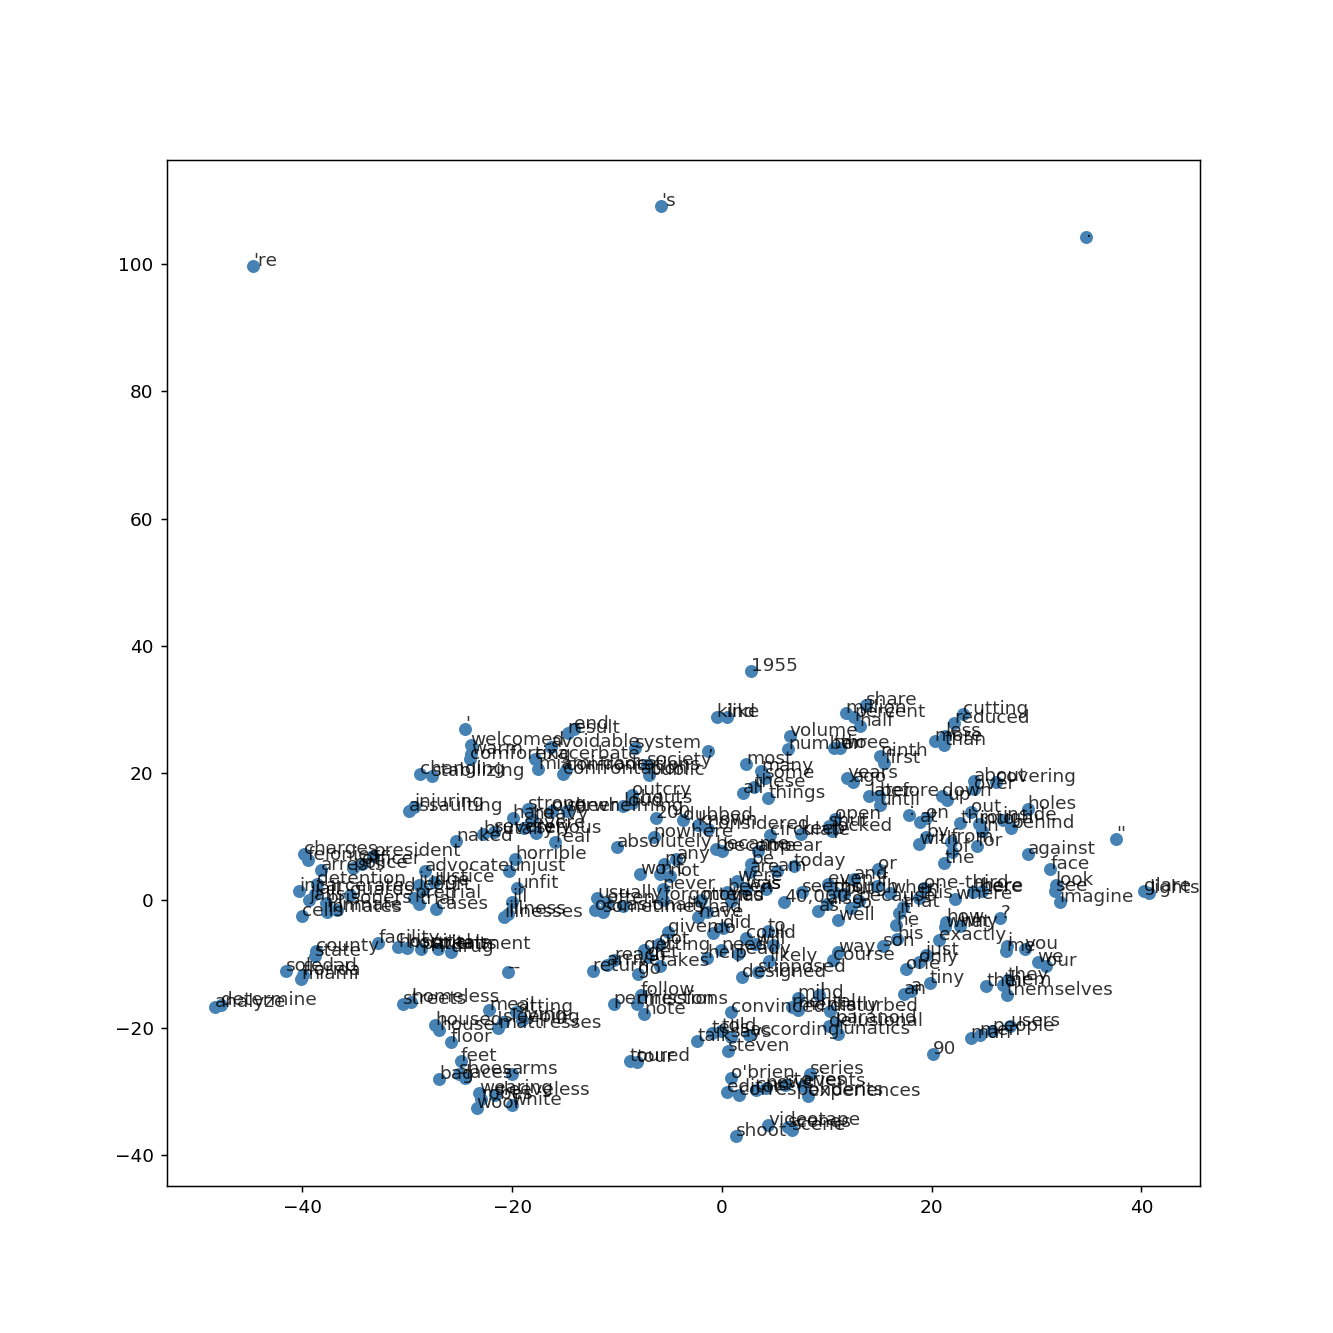

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color = 'steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.8)

### model_inputs()
To create TF Placeholders for the Neural Network:

In [5]:
def model_inputs():
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob') # new

    summary_length = tf.placeholder(tf.int32, (None,), name='summary_length')
    max_summary_length = tf.reduce_max(summary_length, name='max_dec_len')
    text_length = tf.placeholder(tf.int32, (None,), name='text_length')
    
    return input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length


# problem_unittests.test_model_inputs(model_inputs)

### process_decoding_input() 

To remove the last word id from each batch in target_data and concat the GO ID to the beginning of each batch

In [6]:
def process_decoding_input(target_data, vocab_to_int, batch_size):
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

### encoding_layer() 
To create an encoder RNN

In [7]:
# bi-direction
def encoding_layer(rnn_size, sequence_length, num_layers, rnn_inputs, keep_prob):
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer)):
            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=52))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=52))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            enc_output, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                    cell_bw, 
                                                                    rnn_inputs,
                                                                    sequence_length,
                                                                    dtype=tf.float32)
            enc_output = tf.concat(enc_output,2)
            # original code is missing this line below, that is how we connect layers 
            # by feeding the current layer's output to next layer's input
            rnn_inputs = enc_output
            
    return enc_output, enc_state

### decoding_layer() 


In [8]:
def training_decoding_layer(dec_embed_input, summary_length, dec_cell, output_layer, vocab_size, 
                            max_summary_length, batch_size):
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                        sequence_length=summary_length,
                                                        time_major=False)

    training_decoder = tf.contrib.seq2seq.BasicDecoder(cell=dec_cell,
                                                       helper=training_helper,
                                                       initial_state=dec_cell.zero_state(dtype=tf.float32, batch_size=batch_size),
                                                       output_layer = output_layer)

    training_logits = tf.contrib.seq2seq.dynamic_decode(training_decoder, 
                                                        output_time_major=False, 
                                                        impute_finished=True, 
                                                        maximum_iterations=max_summary_length)
    
    return training_logits

In [9]:
def inference_decoding_layer(embeddings, start_token, end_token, dec_cell, output_layer,
                             max_summary_length, batch_size):
    '''Create the inference logits'''
    
    start_tokens = tf.tile(tf.constant([start_token], dtype=tf.int32), [batch_size], name='start_tokens')
    
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embeddings,start_tokens, end_token)
                
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                        inference_helper,
                                                        dec_cell.zero_state(dtype=tf.float32, batch_size=batch_size),
                                                        output_layer)
                
    inference_logits = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                         output_time_major=False,
                                                         impute_finished=True,
                                                         maximum_iterations=max_summary_length)
    
    return inference_logits

Attention:
Using Bhadanau, since trains faster than Luong.

AttentionWrapper: 
applies the attention mechanism to our decoding cell.

parameters

- dec_embed_input: output of embedding_lookup for a batch of inputs
- embeddings: the CN's word_embedding_matrix
- enc_output: encoder layer output, containing the forward and the backward rnn output
- enc_state: encoder layer state, a tuple containing the forward and the backward final states of bidirectional rnn.
- vocab_size: vocabulary size i.e. len(vocab_to_int)+1
- text_length: the actual lengths for each of the input text sequences in the batch
- summary_length: the actual lengths for each of the input summary sequences in the batch
- max_summary_length: the maximum length of a summary in a batch
- rnn_size: The number of units in the LSTM cell
- vocab_to_int: vocab_to_int the dictionary
- keep_prob: RNN dropout input keep probability
- batch_size: number of input sequences in a batch
- num_layers: number of decoder RNN layer

In [10]:
### TODO TEST L.RELU ACTIVATION

def lstm_cell(lstm_size, keep_prob):
    cell = tf.contrib.rnn.BasicLSTMCell(lstm_size, activation=tf.nn.leaky_relu)
    
    return tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob = keep_prob)


def decoding_layer(dec_embed_input, embeddings, enc_output, 
                   enc_state, vocab_size, text_length, 
                   summary_length, max_summary_length, rnn_size, 
                   vocab_to_int, keep_prob, batch_size, num_layers):
    '''Create the decoding cell and attention for the training and inference decoding layers'''
    
    dec_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell(rnn_size, keep_prob) for _ in range(num_layers)])
    
    output_layer = Dense(vocab_size, kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
    attn_mech = tf.contrib.seq2seq.BahdanauAttention(rnn_size,
                                                     enc_output,
                                                     text_length,
                                                     normalize=False,
                                                     name='BahdanauAttention')
    
    dec_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell, attn_mech, rnn_size)
    
    with tf.variable_scope("decode"):
        training_logits = training_decoding_layer(dec_embed_input, summary_length, dec_cell,
                                                  output_layer, vocab_size, max_summary_length, batch_size)
        
    with tf.variable_scope("decode", reuse=True):
        inference_logits = inference_decoding_layer(embeddings,
                                                    vocab_to_int['<GO>'],
                                                    vocab_to_int['<EOS>'],
                                                    dec_cell,
                                                    output_layer,
                                                    max_summary_length,
                                                    batch_size)
        
    return training_logits, inference_logits

### Seq2seq model

merge encoder with decoder:

In [11]:
def seq2seq_model(input_data, target_data, keep_prob, text_length, summary_length, max_summary_length, 
                  vocab_size, rnn_size, num_layers, vocab_to_int, batch_size):
    
    # Use Numberbatch's embeddings and the newly created ones as our embeddings
    embeddings = word_embedding_matrix
    
    # TODO: create own embedding matrix? 
    # dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, 300]))

    enc_embed_input = tf.nn.embedding_lookup(embeddings, input_data)
    
    enc_output, enc_state = encoding_layer(rnn_size, text_length, num_layers, enc_embed_input, keep_prob)
    
    dec_input = process_decoding_input(target_data, vocab_to_int, batch_size) #shape=(batch_size, senquence length) each seq start with index of<GO>
    
    dec_embed_input = tf.nn.embedding_lookup(embeddings, dec_input)
    
    training_logits, inference_logits  = decoding_layer(dec_embed_input, 
                                                        embeddings,
                                                        enc_output,
                                                        enc_state, 
                                                        vocab_size, 
                                                        text_length, 
                                                        summary_length, 
                                                        max_summary_length,
                                                        rnn_size, 
                                                        vocab_to_int, 
                                                        keep_prob, 
                                                        batch_size,
                                                        num_layers)
    
    return training_logits, inference_logits

### Get batches

In [12]:
# Pad articles/abstracts with <PAD> so that each articles/abstracts of a batch has the same length

def pad_batch(article_batch):
    
    max_article = max([len(a) for a in article_batch])
    
    return [a + [vocab_to_int['<PAD>']] * (max_article - len(a)) for a in article_batch]

In [13]:
# Batch targets, sources, and the lengths of their articles/abstracts together

def get_batches(summaries, texts, batch_size):
    for batch_i in range(0, len(texts)//batch_size):
        start_i = batch_i * batch_size
        summaries_batch = summaries[start_i:start_i + batch_size]
        texts_batch = texts[start_i:start_i + batch_size]
        pad_summaries_batch = np.array(pad_batch(summaries_batch))
        pad_texts_batch = np.array(pad_batch(texts_batch))
        
        # Need the lengths for the _lengths parameters
        pad_summaries_lengths = []
        for summary in pad_summaries_batch:
            pad_summaries_lengths.append(len(summary))
        
        pad_texts_lengths = []
        for text in pad_texts_batch:
            pad_texts_lengths.append(len(text))
        
        yield pad_summaries_batch, pad_texts_batch, pad_summaries_lengths, pad_texts_lengths

### Hyperparameters


In [16]:
# Number of Epochs
epochs = 10

# Batch Size
batch_size = 8

# RNN Size
rnn_size = 512

# Number of Layers
num_layers = 3


keep_probability = 0.7

# Learning Rate
learning_rate = 0.001
learning_rate_decay = 0.95
min_learning_rate = 0.0005

display_step = 128 # Check training loss after every n batches
stop_early = 0 
stop = 3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 32 # Make n update checks per epoch 
update_check = (len(sorted_texts)//batch_size//per_epoch)-1

update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model

In [15]:
# TODO WARNINGS

# Build the graph

train_graph = tf.Graph()
# Set the graph to default to ensure that it is ready for training
with train_graph.as_default():
    
    # Load the model inputs    
    input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length = model_inputs()

    # Create the training and inference logits
    # 
    training_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                      targets, 
                                                      keep_prob,   
                                                      text_length,
                                                      summary_length,
                                                      max_summary_length,
                                                      len(vocab_to_int)+1,
                                                      rnn_size, 
                                                      num_layers, 
                                                      vocab_to_int,
                                                      batch_size)
    
    # Create tensors for the training logits and inference logits
    training_logits = tf.identity(training_logits[0].rnn_output, 'logits')
    inference_logits = tf.identity(inference_logits[0].sample_id, name='predictions')
    
    # Create the weights for sequence_loss, the sould be all True across since each batch is padded
    masks = tf.sequence_mask(summary_length, max_summary_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(training_logits, targets, masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
        
print("Graph is built!")
graph_location = "./graph"
print(graph_location)

train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(train_graph)

Instructions for updating:
seq_dim is deprecated, use seq_axis instead
Instructions for updating:
batch_dim is deprecated, use batch_axis instead
Graph is built!
./graph


### Train!

In [ ]:
# TODO
# Train the Model - NEW

checkpoint = "./best_model.ckpt" 

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session
    #loader = tf.train.import_meta_graph("./" + checkpoint + '.meta')
    #loader.restore(sess, checkpoint)
    
    for epoch_i in range(1, epochs+1):
        update_loss = 0
        batch_loss = 0
        for batch_i, (summaries_batch, texts_batch, summaries_lengths, texts_lengths)\
        in enumerate(get_batches(sorted_summaries, sorted_texts, batch_size)):
            start_time = time.time()
            # training step
            _, loss = sess.run([train_op, cost], {input_data: texts_batch, 
                                                  targets: summaries_batch, 
                                                  lr: learning_rate, 
                                                  summary_length: summaries_lengths, 
                                                  text_length: texts_lengths, 
                                                  keep_prob: keep_probability})

            batch_loss += loss
            update_loss += loss
            end_time = time.time()
            batch_time = end_time - start_time

            if batch_i % display_step == 0 and batch_i > 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(sorted_texts) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0

            if batch_i % update_check == 0 and batch_i > 0:
                print("Average loss for this update:", round(update_loss/update_check,3))
                summary_update_loss.append(update_loss)
                
                # If the update loss is at a new minimum, save the model
                if update_loss <= min(summary_update_loss):
                    print('New Minimum!') 
                    stop_early = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    stop_early += 1
                    if stop_early == stop:
                        break
                update_loss = 0
            
                    
        # Reduce learning rate, but not below its minimum value
        learning_rate *= learning_rate_decay
        if learning_rate < min_learning_rate:
            learning_rate = min_learning_rate
        
        if stop_early == stop:
            print("Stopping Training...")
            break

In [ ]:
# OLD
# TODO early stop
# TODO use this better ?


(valid_targets_batch, valid_sources_batch, 
 valid_targets_lengths, valid_sources_lengths) = next(get_batches(sorted_summaries,
                                                                  sorted_texts,
                                                                  batch_size))
#                                                                   source_vocab_to_int['<PAD>'],
#                                                                   target_vocab_to_int['<PAD>']))

display_step = 10 # Check training loss after every n batches

checkpoint = "best_model.ckpt" 
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
        
    for epoch_i in range(1, epochs+1):
        for batch_i, (targets_batch, sources_batch, targets_lengths, sources_lengths) in\
        enumerate(get_batches(sorted_summaries, sorted_texts, batch_size)):
#                               source_vocab_to_int['<PAD>'],target_vocab_to_int['<PAD>'])):
            
            # Training step
            _, loss = sess.run([train_op, cost], {input_data: sources_batch, 
                                                  targets: targets_batch, 
                                                  lr: learning_rate, 
                                                  summary_length: targets_lengths, 
                                                  text_length: sources_lengths, 
                                                  keep_prob: keep_probability})

            # Debug message updating us on the status of the training
            if batch_i % display_step == 0 and batch_i > 0:
                
                # Calculate validation cost
                validation_loss = sess.run([cost], {input_data: valid_sources_batch, 
                                                    targets: valid_targets_batch,
                                                    lr: learning_rate,
                                                    summary_length: valid_targets_lengths,
                                                    text_length: valid_sources_lengths})
                
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}  - Validation loss: {:>6.3f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(train_source) // batch_size, 
                              loss, 
                              validation_loss[0]))

    
    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, checkpoint)
    print('Model Trained and Saved')

### Prediction!

In [7]:
def text_to_seq(text):
    
    return [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in text.split()]

In [14]:
input_sentences=["SINGAPORE: Keppel Offshore & Marine’s (Keppel O&M) involvement in an international corruption scandal came to light last month as Singapore’s largest oil rig builder said it would pay a hefty fine as part of a global resolution with authorities in three countries. The settlement, reached with criminal authorities in the United States, Brazil and Singapore, is unprecedented for a local company. So is the penalty, totalling US$422 million (S$567 million), which is believed to be a record involving a Singapore-listed entity. The corrupt payments of US$55 million made between 2001 and 2014 also surpassed the bribes unearthed in a corruption bust at shipbuilder Singapore Technologies Marine (ST Marine) in 2014. Then, at least S$24.9 million in bribes were falsely claimed as entertainment expenses and made to employees of ST Marine's customers in return for ship repair contracts. Seven former ST Marine executives were convicted last year for their part in the graft scandal. The latest bribery scandal involving Keppel O&M, a unit of conglomerate Keppel Corporation, has raised questions about its corporate governance and caused turbulence, albeit temporarily, in the shares of mainboard-listed Keppel. State investment firm Temasek Holdings holds a 20.43 per cent stake in Keppel as of Aug 15, 2017.", 
                 "david nalbandian battled back to stun world no. 1 roger federer with a 1-6 6-3 6-3 victory in the final of the madrid masters on sunday . david nalbandian celebrates after upsetting roger federer in the madrid masters final . the argentine , ranked 25th in the world , repeated his 2005 upset win over the swiss star in that year 's season-ending masters cup -- also an indoor event . defending champion federer , playing in his first tournament since winning the u.s. open six weeks ago , made 38 unforced errors . nalbandian became only the third player -- and the second this year after novak djokovic in montreal in august -- to beat the world 's top-three players en route to winning a title . german legend boris becker was the first to perform the feat 13 years ago . nalbandian ousted second-ranked rafael nadal in the quarterfinals and then serbian djokovic in saturday 's semis . the 25-year-old , who lost in the madrid final in 2004 , claimed his first triumph on the atp tour since may , 2006 , on clay in portugal . he spent a year without a coach , but has revived his career since teaming up with hernan gumy . `` i 'm extremely contented to beat the world number one , '' nalbandian said . `` roger and i have a long history and i think that influenced the match . `` it was an extremely hard first set . but i tightened the teeth and i began to play more strongly . things came out fine , i played incredible , and that of course that helps . '' federer added : `` he served well , i was quite surprised with how well he served . `` he came back strong and played well in the end . `` he was a better player all in all . i was struggling after the first set to play aggressively , for some reason . he played tough and did n't miss any more . i could n't play way i wanted to . it was a pity , he played a great tournament ."]

generate_summary_length = [50,45] # 2 inputs

texts = [text_to_seq(article) for article in input_sentences]

In [15]:
checkpoint = "./best_model.ckpt"

if type(generate_summary_length) is list:
    if len(input_sentences) != len(generate_summary_length):
        raise Exception("[Error] makeSummaries parameter generate_summary_length must be same length as input_sentences or an integer")
    generate_summary_length_list = generate_summary_length
else:
    generate_summary_length_list = [generate_summary_length] * len(texts)

loaded_graph = tf.Graph()

with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)
    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    text_length = loaded_graph.get_tensor_by_name('text_length:0')
    summary_length = loaded_graph.get_tensor_by_name('summary_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
    # Multiply by batch_size to match the model's input parameters
    for i, text in enumerate(texts):
        generate_summary_length = generate_summary_length_list[i]
        answer_logits = sess.run(logits, {input_data: [text]*batch_size, 
                                          summary_length: [generate_summary_length], #summary_length: [np.random.randint(5,8)], 
                                          text_length: [len(text)]*batch_size,
                                          keep_prob: 1.0})[0] 
        # Remove the padding from the summaries
        pad = vocab_to_int["<PAD>"] 
        print('- Article:\n\r {}'.format(input_sentences[i]))
        print('- Abstract:\n\r {}\n\r\n\r'.format(" ".join([int_to_vocab[i] for i in answer_logits if i != pad])))

INFO:tensorflow:Restoring parameters from ./best_model.ckpt
- Article:
 SINGAPORE: Keppel Offshore & Marine’s (Keppel O&M) involvement in an international corruption scandal came to light last month as Singapore’s largest oil rig builder said it would pay a hefty fine as part of a global resolution with authorities in three countries. The settlement, reached with criminal authorities in the United States, Brazil and Singapore, is unprecedented for a local company. So is the penalty, totalling US$422 million (S$567 million), which is believed to be a record involving a Singapore-listed entity. The corrupt payments of US$55 million made between 2001 and 2014 also surpassed the bribes unearthed in a corruption bust at shipbuilder Singapore Technologies Marine (ST Marine) in 2014. Then, at least S$24.9 million in bribes were falsely claimed as entertainment expenses and made to employees of ST Marine's customers in return for ship repair contracts. Seven former ST Marine executives were co